# Visualising Features

In [17]:

%load_ext autoreload
%autoreload 2

from os.path import join
import joblib
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import sys


sys.path.append("../../")

from src.models.bilateral.regularizer import SparseRegularizer
from src.models.bilateral.groupedSoftmaxDenseLayer import GroupedSoftmaxDenseLayer
from src.feature_visualisation.feat_extraction import get_all_layer_outputs, get_tsne_features, get_pca_features
from src.feature_visualisation.display_feat import display_features
from src.feature_visualisation.compute_sparsity import calculate_sparsity_of_encoder_features
from src.preprocessing.tabular_preprocessing import add_noise
from src.misc import create_folder
from src.configs.config import fp_checkpoint_folder, fp_data_folder  # Edit this
from src.preprocessing.tabular_preprocessing import choose_output_cols

fp_feature_folder = join(fp_checkpoint_folder, "features")
fp_col_info_file = join(fp_data_folder, "col_info.joblib")
fp_data_dfs_file = join(fp_data_folder, "data_dfs.joblib")
fp_model_checkpoints = join(fp_checkpoint_folder, "models")
fp_fc_model_checkpoint = join(fp_model_checkpoints, "fc_softmax")
fp_fc_model_partial_checkpoint = join(fp_model_checkpoints, "fc_softmax_1_epochs_less")

# (a) Regular
fp_feature_file = join(fp_feature_folder, "bilateral_features.joblib")
fp_tsne_feature_file = join(fp_feature_folder, "tsne_features.joblib")
fp_pca_feature_file = join(fp_feature_folder, "pca_features.joblib")
fp_intermediate_feat_fig_file = join(fp_feature_folder, "intermediate_feat.jpg")
fp_fully_trained_fig_file = join(fp_feature_folder, "fully_trained_feat.jpg")
# (b) Some Trained
fp_feature_partial_file = join(fp_feature_folder, "bilateral_features_partial.joblib")
fp_tsne_feature_partial_file = join(fp_feature_folder, "tsne_features_partial.joblib")
fp_pca_feature_partial_file = join(fp_feature_folder, "pca_features_partial.joblib")
fp_partially_trained_fig_file = join(fp_feature_folder, "partially_trained_feat.jpg")
# (c) Noisy
fp_feature_noisy_file = join(fp_feature_folder, "bilateral_features_noisy.joblib")
fp_tsne_feature_noisy_file = join(fp_feature_folder, "tsne_features_noisy.joblib")
fp_pca_feature_noisy_file = join(fp_feature_folder, "pca_features_noisy.joblib")
fp_intermediate_feat_noisy_fig_file = join(fp_feature_folder, "intermediate_feat_noisy.jpg")

create_folder(fp_feature_folder)

seed_no = 2024
batch_size=16


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [18]:
data_dfs = joblib.load(fp_data_dfs_file)
col_info = joblib.load(fp_col_info_file)
col_info = choose_output_cols(col_info, bilateral=False)
col_info

{'input_cols': ['Vision Test',
  'VA',
  'IOP',
  'Gradable',
  'Cup Disc Ratio',
  'OCT RNFL_Abnormal (Progressing)',
  'OCT RNFL_Abnormal (Stable)',
  'OCT RNFL_Normal',
  'OCT RNFL_Unreliable',
  'OCT RNFL_nan',
  'MAC GCA_Abnormal (Progressing)',
  'MAC GCA_Abnormal (Stable)',
  'MAC GCA_Normal',
  'MAC GCA_Unreliable',
  'MAC GCA_nan',
  'HVF_Abnormal (Stable)',
  'HVF_Normal',
  'HVF: flat, no IRF/SRF.',
  'HVF_Unreliable',
  'HVF_nan',
  'DRF_DH/MA',
  'DRF_CWS',
  'DRF_BH',
  'DRF_FH',
  'DRF_NVE',
  'DRF_IRMA',
  'DRF_PRH',
  'DRF_10M',
  'DMF_DH/MA',
  'DMF_BH',
  'DMF_Inner',
  'DMF_Better',
  'DMF_HE',
  'AMDF_DDin',
  'AMDF_GT125',
  'AMDF_PA',
  'AMDF_GA',
  'AMDF_PED',
  'AMDF_SFS',
  'AMDF_SR/subRPE',
  'AMDF_CNVM',
  'GSF_RT',
  'GSF_Notch',
  'GSF_CDR',
  'GSF_DA',
  'GSF_DH',
  'OCTM_IRF',
  'OCTM_Normal',
  'OCTM_Atrophy',
  'OCTM_ERMpreservedFC',
  'OCTM_Others',
  'OCTM_ISOSloss',
  'OCTM_VRtraction',
  'OCTM_Drusen',
  'OCTM_ERMdetVA',
  'OCTM_ERMlossFC',
  'OCTM

##  a) The distribution in at least 4 intermediate layers to show how their network is classifying

In [3]:
# Load model
fc_bilateral_model = tf.keras.models.load_model(fp_fc_model_checkpoint)

In [4]:
# Get Layer Outputs
print("=== Get Layer Outputs ===")
layer_output_dict = get_all_layer_outputs(
    model=fc_bilateral_model, pred_df=data_dfs["test_df"],
    col_info=col_info)
joblib.dump(layer_output_dict, fp_feature_file)
# Dim Reduction Features
print("=== Get TSNE Features ===")
tsne_feat_dict = get_tsne_features(layer_output_dict, seed=seed_no) 
joblib.dump(tsne_feat_dict , fp_tsne_feature_file)
print("=== Get PCA Features ===")
pca_feat_dict = get_pca_features(layer_output_dict, seed=seed_no) 
joblib.dump(pca_feat_dict , fp_pca_feature_file)

=== Get Layer Outputs ===
1. Get Encoder Features
	 - Took 0.11090254783630371s
2. Get Intermediate Classifier Features


100%|██████████| 4/4 [00:00<00:00, 52.91it/s]


	 - Took 0.08387970924377441s
3. Get Final Classifier Features
	 - Took 0.4962127208709717s
=== Get TSNE Features ===


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


=== Get PCA Features ===


100%|██████████| 6/6 [00:00<00:00, 133.09it/s]


['../checkpoints\\features\\pca_features.joblib']

In [7]:
# Compuet Sparsity
layer_output_dict = joblib.load(fp_feature_file)
calculate_sparsity_of_encoder_features(layer_output_dict['Encoder_Feature'], dp=5)

,Eye,Sparsity
0,LE,0.895910
1,RE,0.890303
2,Both,0.893107


  0%|          | 0/6 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


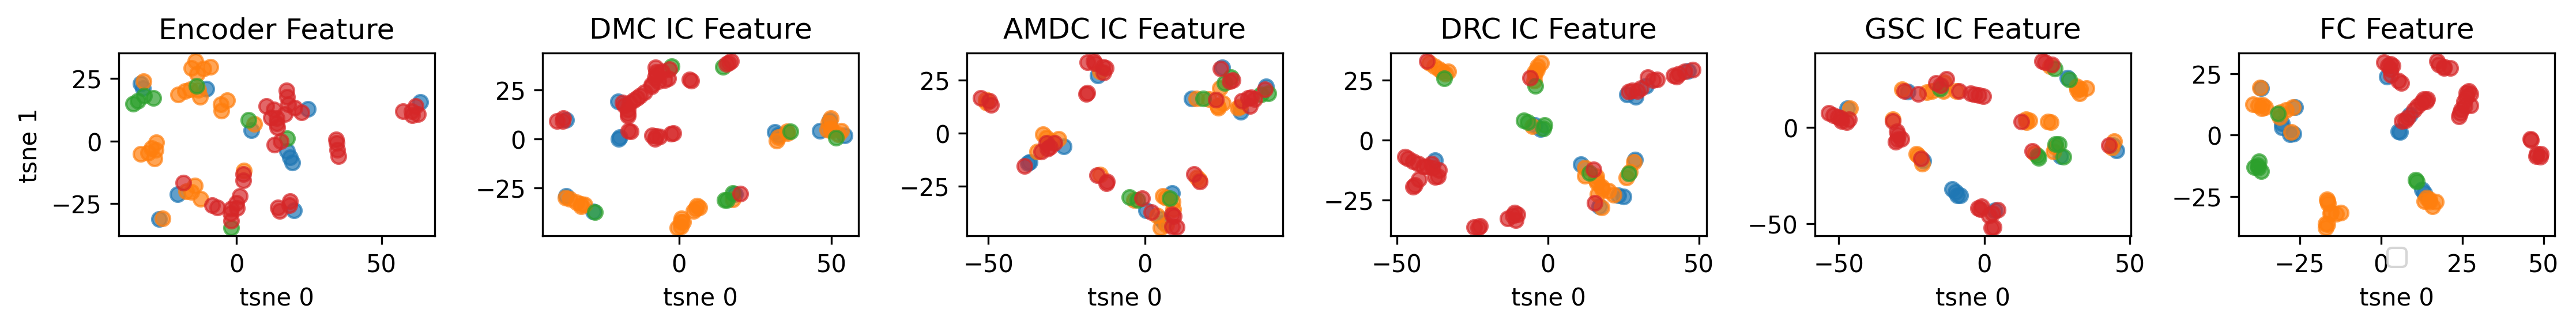

In [ ]:
tsne_feat_dict = joblib.load(fp_tsne_feature_file)
display_features(tsne_feat_dict, col_info, ncols=6) # , ignore_feat=["Encoder_Feature"]
# plt.savefig(fp_intermediate_feat_fig_file, bbox_inches="tight")

  0%|          | 0/6 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


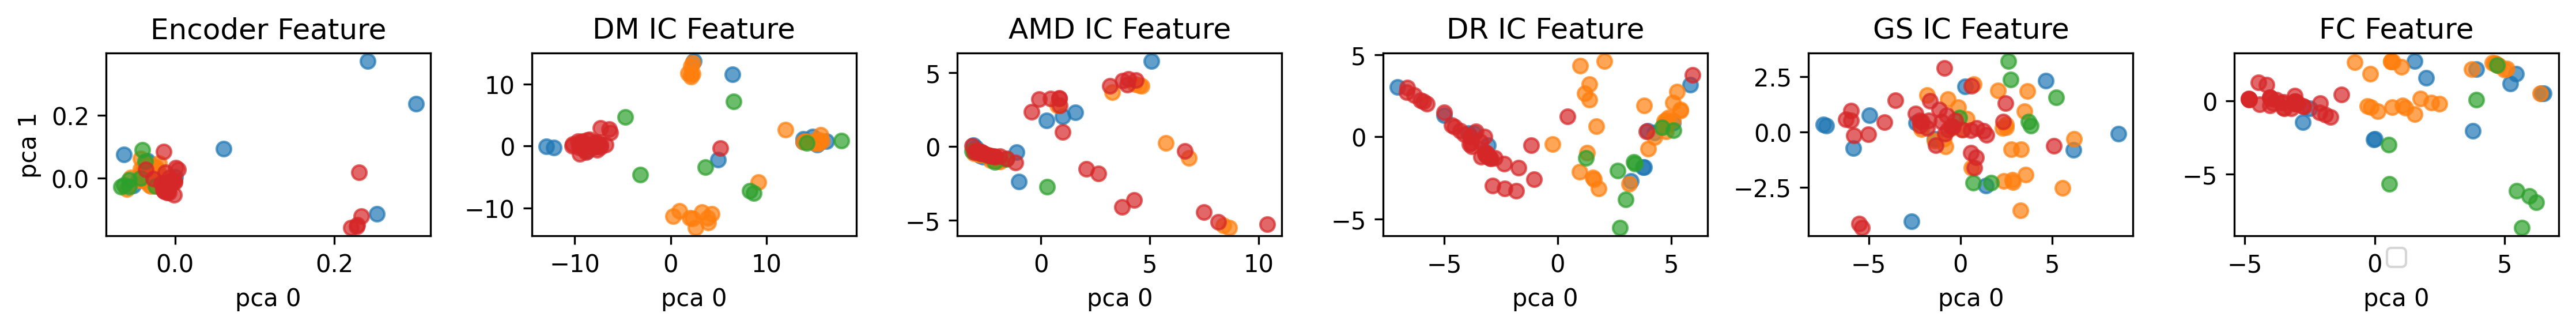

In [32]:
pca_feat_dict = joblib.load(fp_pca_feature_file)
display_features(pca_feat_dict, col_info, ncols=6) # , ignore_feat=["Encoder_Feature"]
plt.savefig(fp_intermediate_feat_fig_file, bbox_inches="tight")

## b) The distribution of data at one layer (preferably one of the final layers) with change in epoch to better understand the feature classification process by their network.

In [12]:
# Load model
fc_bilateral_partial_model = tf.keras.models.load_model(fp_fc_model_partial_checkpoint)

In [16]:
# Get Layer Outputs
print("=== Get Layer Outputs ===")
layer_output_partial_dict = get_all_layer_outputs(
    model=fc_bilateral_partial_model, pred_df=data_dfs["test_df"], # Change this
    col_info=col_info)
joblib.dump(layer_output_partial_dict, fp_feature_partial_file)
# Dim Reduction Features
print("=== Get TSNE Features ===")
tsne_feat_partial_dict = get_tsne_features(layer_output_partial_dict, perplexity=1, seed=seed_no) # Remove this
joblib.dump(tsne_feat_partial_dict , fp_tsne_feature_partial_file)
print("=== Get PCA Features ===")
pca_feat_partial_dict = get_pca_features(layer_output_partial_dict, seed=seed_no) 
joblib.dump(pca_feat_partial_dict , fp_pca_feature_partial_file)

=== Get Layer Outputs ===
1. Get Encoder Features
	 - Took 0.026905059814453125s
2. Get Intermediate Classifier Features


100%|██████████| 4/4 [00:00<00:00, 85.97it/s]


	 - Took 0.047528743743896484s
3. Get Final Classifier Features
	 - Took 0.11559677124023438s
=== Get TSNE Features ===


100%|██████████| 6/6 [00:01<00:00,  4.45it/s]


=== Get PCA Features ===


100%|██████████| 6/6 [00:00<00:00, 154.84it/s]


['../checkpoints\\features\\pca_features_partial.joblib']

  0%|          | 0/6 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


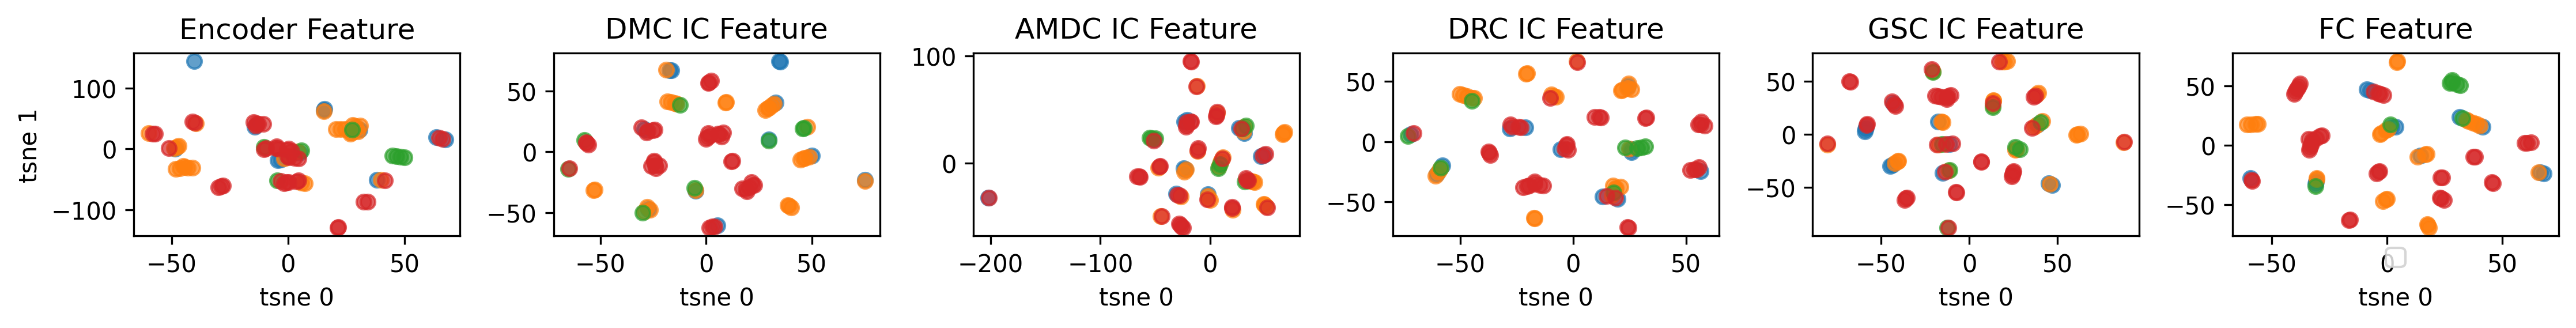

In [ ]:
tsne_feat_partial_dict = joblib.load(fp_tsne_feature_partial_file)
display_features(tsne_feat_partial_dict, col_info, ncols=6) # , ignore_feat=["Encoder_Feature"]
# plt.savefig(fp_partially_trained_fig_file, bbox_inches="tight")

  0%|          | 0/6 [00:00<?, ?it/s]

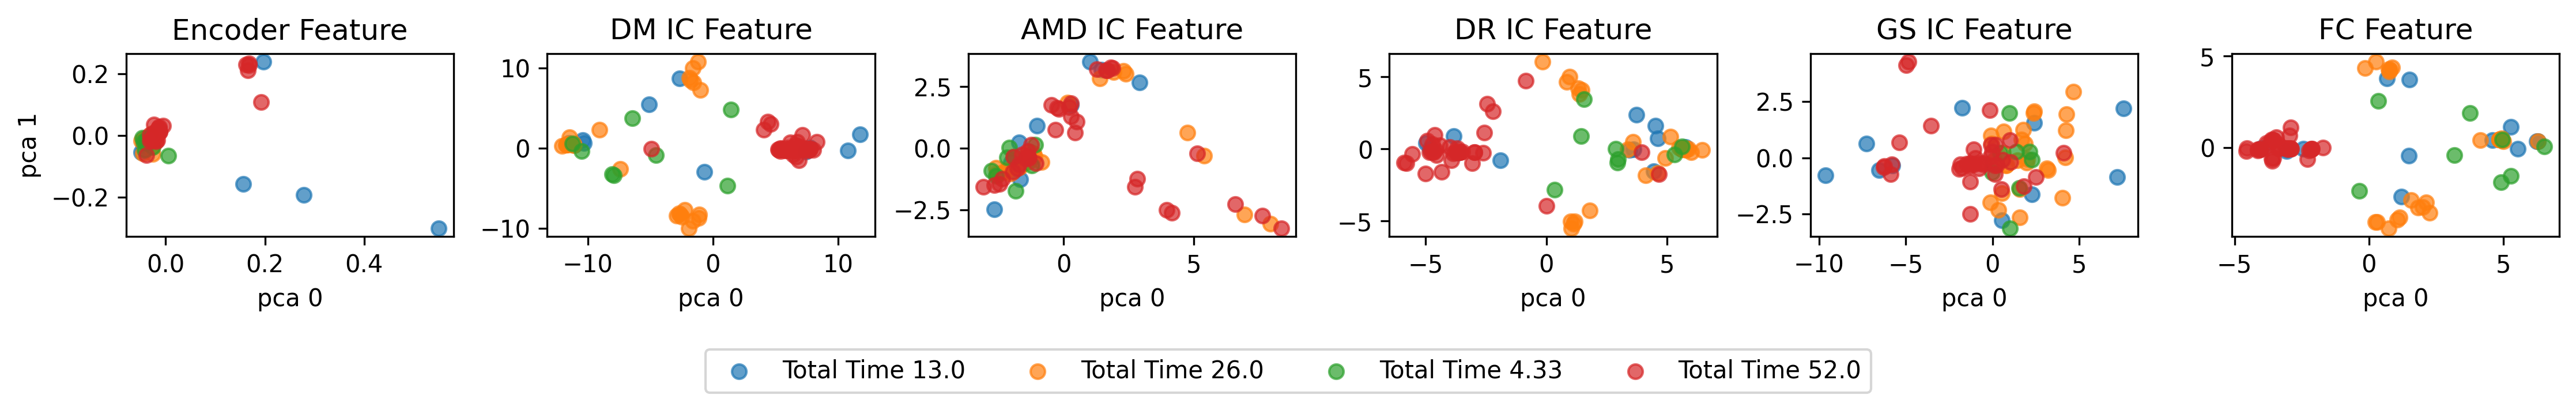

In [37]:
pca_feat_partial_dict = joblib.load(fp_pca_feature_partial_file)
display_features(pca_feat_partial_dict, col_info, ncols=6, add_legend=True) # , ignore_feat=["Encoder_Feature"]
plt.savefig(fp_partially_trained_fig_file, bbox_inches="tight")

## c) Add some Gaussian noise to the input data and then show the feature distribution using MDA to visualize the robustness of their network.

In [23]:
# Load model
fc_bilateral_model = tf.keras.models.load_model(fp_fc_model_checkpoint)

In [24]:
# Make noisy data
data_dfs_noisy = add_noise(data_dfs=data_dfs, std=0.05, col_info=col_info, seed=seed_no)
print("Before:")
display(data_dfs["train_df"].head())
print("After:")
display(data_dfs_noisy["train_df"].head())

Before:


,Vision Test LE,VA LE,IOP LE,Gradable LE,Cup Disc Ratio LE,OCT RNFL_Abnormal (Progressing) LE,OCT RNFL_Abnormal (Stable) LE,OCT RNFL_Normal LE,OCT RNFL_Unreliable LE,OCT RNFL_nan LE,...,Total_Time >= 1.0,Total_Time >= 4.33,Total_Time >= 13.0,Total_Time >= 26.0,Total_Time >= 52.0,Total_Time_1.0,Total_Time_4.33,Total_Time_13.0,Total_Time_26.0,Total_Time_52.0
274,1.0,0.000000,0.769231,1.0,0.894737,1,0,0,0,0,...,1,1,1,0,0,0,0,1,0,0
126,0.0,0.000000,0.307692,1.0,0.736842,0,0,0,0,1,...,1,1,1,1,1,0,0,0,0,1
261,1.0,0.000000,0.461538,1.0,0.736842,0,0,0,0,1,...,1,1,1,1,1,0,0,0,0,1
472,0.0,0.222222,0.461538,1.0,0.842105,0,0,0,0,1,...,1,1,1,1,0,0,0,0,1,0
648,0.0,0.333333,0.692308,1.0,0.684211,0,0,0,0,1,...,1,1,1,1,1,0,0,0,0,1


After:


,Vision Test LE,VA LE,IOP LE,Gradable LE,Cup Disc Ratio LE,OCT RNFL_Abnormal (Progressing) LE,OCT RNFL_Abnormal (Stable) LE,OCT RNFL_Normal LE,OCT RNFL_Unreliable LE,OCT RNFL_nan LE,...,Total_Time >= 1.0,Total_Time >= 4.33,Total_Time >= 13.0,Total_Time >= 26.0,Total_Time >= 52.0,Total_Time_1.0,Total_Time_4.33,Total_Time_13.0,Total_Time_26.0,Total_Time_52.0
274,1.083402,0.036867,0.759154,0.992454,0.940539,1.058016,-0.130998,-0.066265,0.022999,0.005103,...,1,1,1,0,0,0,0,1,0,0
126,0.005484,0.094726,0.337202,1.009169,0.705405,-0.055564,-0.047601,0.088889,0.027689,0.981962,...,1,1,1,1,1,0,0,0,0,1
261,0.909417,0.005669,0.422600,0.992110,0.786069,0.015911,-0.008135,-0.009303,0.000283,0.926683,...,1,1,1,1,1,0,0,0,0,1
472,-0.025759,0.309698,0.491858,1.001432,0.822426,-0.092407,0.099462,-0.032871,-0.023148,1.087225,...,1,1,1,1,0,0,0,0,1,0
648,0.059332,0.355672,0.677669,1.067524,0.673084,-0.066080,0.000641,-0.035739,-0.021540,1.178807,...,1,1,1,1,1,0,0,0,0,1


In [26]:
# Get Layer Outputs
print("=== Get Layer Outputs ===")
layer_output_noisy_dict = get_all_layer_outputs(
    model=fc_bilateral_model, pred_df=data_dfs_noisy["test_df"], 
    col_info=col_info)
joblib.dump(layer_output_noisy_dict, fp_feature_noisy_file)
# Dim Reduction Features
print("=== Get TSNE Features ===")
tsne_feat_noisy_dict = get_tsne_features(layer_output_noisy_dict, seed=seed_no) 
joblib.dump(tsne_feat_noisy_dict , fp_tsne_feature_noisy_file)
print("=== Get PCA Features ===")
pca_feat_noisy_dict = get_pca_features(layer_output_noisy_dict, seed=seed_no) 
joblib.dump(pca_feat_noisy_dict , fp_pca_feature_noisy_file)


=== Get Layer Outputs ===
1. Get Encoder Features
	 - Took 0.03029775619506836s
2. Get Intermediate Classifier Features


100%|██████████| 4/4 [00:00<00:00, 84.19it/s]

	 - Took 0.04751420021057129s
3. Get Final Classifier Features


	 - Took 0.13750600814819336s
=== Get TSNE Features ===


100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


=== Get PCA Features ===


100%|██████████| 6/6 [00:00<00:00, 153.02it/s]


['../checkpoints\\features\\pca_features_noisy.joblib']

  0%|          | 0/6 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


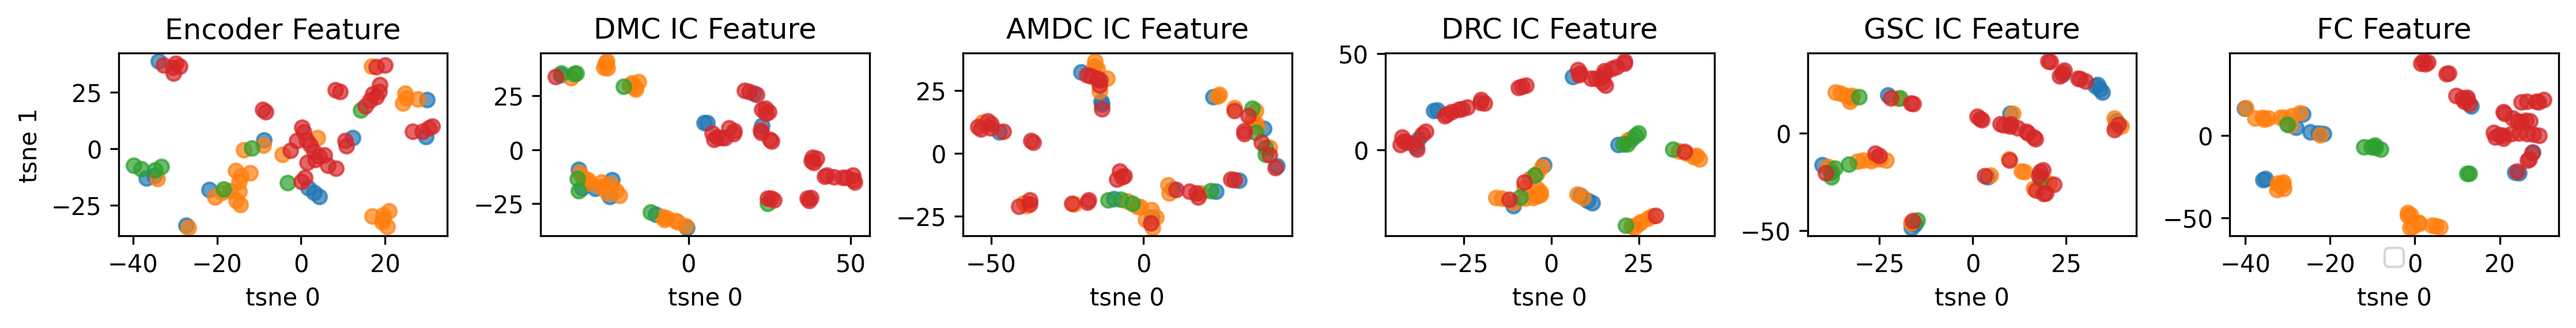

In [ ]:
tsne_feat_noisy_dict = joblib.load(fp_tsne_feature_noisy_file)
display_features(tsne_feat_noisy_dict, col_info, ncols=6) # , ignore_feat=["Encoder_Feature"]
# plt.savefig(fp_intermediate_feat_noisy_fig_file, bbox_inches="tight")

  0%|          | 0/6 [00:00<?, ?it/s]

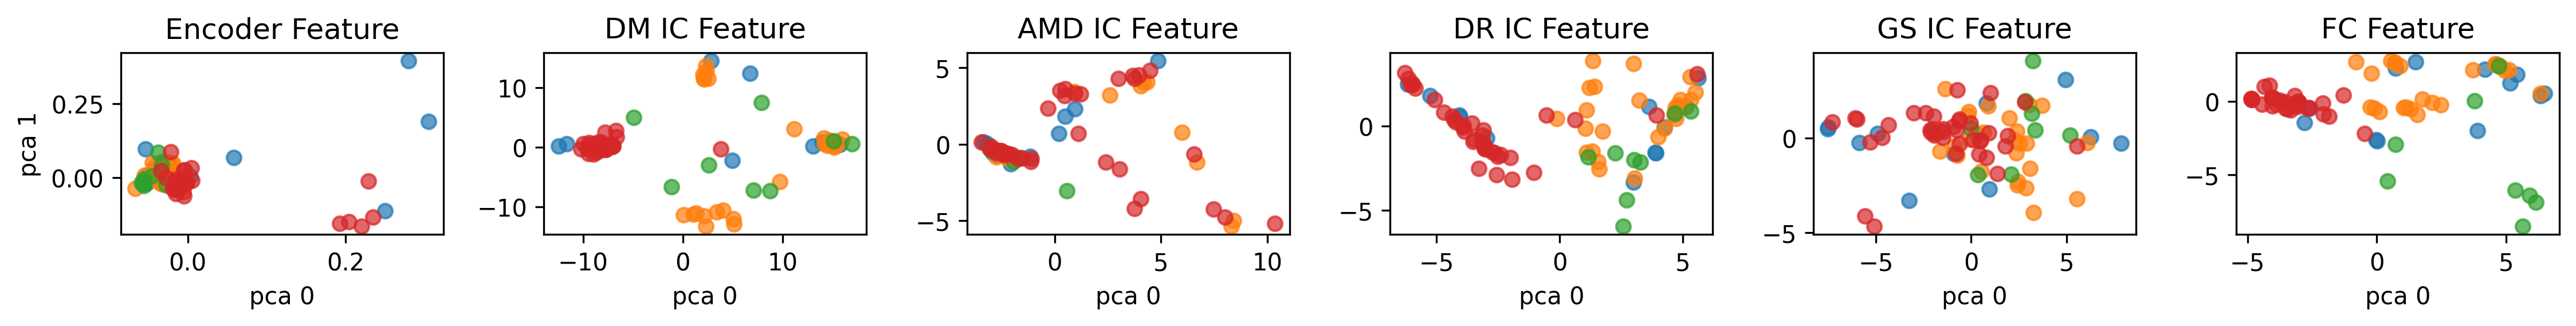

In [36]:
pca_feat_noisy_dict = joblib.load(fp_pca_feature_noisy_file)
display_features(pca_feat_noisy_dict, col_info, ncols=6) # , ignore_feat=["Encoder_Feature"]
plt.savefig(fp_intermediate_feat_noisy_fig_file, bbox_inches="tight")